### Transfer Learning 

In [9]:
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time 
import os
import copy
plt.ion()

In [11]:
data_transforms = {
    'train': transforms.Compose([
       transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [12]:
# Uncomment the line to download the dataset
# !wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
# unzip hymenoptera_data.zip

In [13]:
data_dir = "hymenoptera_data"

In [14]:
image_datasets={x:datasets.ImageFolder(os.path.join(data_dir,x), 
                                       data_transforms[x]
                                      ) for x in ['train','val']}

In [16]:
dataloader = {x:torch.utils.data.DataLoader(image_datasets[x],batch_size=4,
                                           shuffle = True, num_workers =4
                                           ) for x in ['train','val']}

In [18]:
dataset_sizes = {x:len(image_datasets[x]) for x in image_datasets.keys()}

In [21]:
class_names = image_datasets['train'].classes

In [25]:
!tree -L 2 hymenoptera_data/



hymenoptera_data/
├── train
│   ├── ants
│   └── bees
└── val
    ├── ants
    └── bees

6 directories, 0 files


In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [43]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    # Remeber to De-Normalize the images
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std*inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated




In [44]:
# Get a batch of training data
inputs, classes = next(iter(dataloader['train']))

# Make a grid from batch


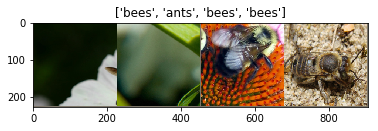

In [45]:
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Tranning the model

In [94]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['train','val']:
            if phase == 'train':
                scheduler.step()
                model.train() # Set the tranning mode
                
            elif phase == 'val':
                model.eval()
            running_loss = 0.0
            running_correct = 0
                
        # Iterate over data.
            for inputs, labels in dataloader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the gradients
                optimizer.zero_grad()


                # forward tranning
                # track history if only in train

                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs,1)
                    loss = criterion(outputs,labels)

                    # backward + optimize
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Stat

                running_loss += loss.item() * inputs.size(0)
                running_correct += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_correct.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # If the current Model is best save the model

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
    print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model



In [100]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [96]:
model_ft = models.resnet18(pretrained=True)
num_fltrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_fltrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001,momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7,gamma=0.1)



In [98]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4566 Acc: 0.8197
val Loss: 0.3538 Acc: 0.8824
Epoch 1/24
----------
train Loss: 0.5620 Acc: 0.7746
val Loss: 0.2938 Acc: 0.9085
Epoch 2/24
----------
train Loss: 0.3285 Acc: 0.8648
val Loss: 0.2888 Acc: 0.8889
Epoch 3/24
----------
train Loss: 0.3207 Acc: 0.8975
val Loss: 0.2730 Acc: 0.8954
Epoch 4/24
----------
train Loss: 0.3072 Acc: 0.8730
val Loss: 0.2831 Acc: 0.8889
Epoch 5/24
----------
train Loss: 0.3199 Acc: 0.8730
val Loss: 0.2177 Acc: 0.9150
Epoch 6/24
----------
train Loss: 0.3405 Acc: 0.8484
val Loss: 0.2394 Acc: 0.9281
Epoch 7/24
----------
train Loss: 0.3304 Acc: 0.8361
val Loss: 0.2268 Acc: 0.9150
Epoch 8/24
----------
train Loss: 0.3101 Acc: 0.8893
val Loss: 0.1962 Acc: 0.9281
Epoch 9/24
----------
train Loss: 0.3068 Acc: 0.8689
val Loss: 0.2130 Acc: 0.9281
Epoch 10/24
----------
train Loss: 0.3138 Acc: 0.8402
val Loss: 0.2210 Acc: 0.9216
Epoch 11/24
----------
train Loss: 0.3700 Acc: 0.8648
val Loss: 0.2322 Acc: 0.9216
Epoch 12/24
--

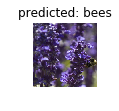

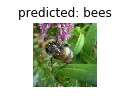

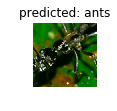

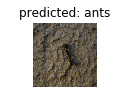

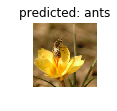

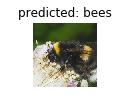

In [101]:
visualize_model(model_ft)

### Using convolution layer as feature Extractor

In [103]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = torch.optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [104]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6912 Acc: 0.5820
val Loss: 0.5417 Acc: 0.7124
Epoch 1/24
----------
train Loss: 0.5628 Acc: 0.7172
val Loss: 0.2577 Acc: 0.9085
Epoch 2/24
----------
train Loss: 0.4406 Acc: 0.8238
val Loss: 0.1909 Acc: 0.9346
Epoch 3/24
----------
train Loss: 0.4322 Acc: 0.8238
val Loss: 0.3291 Acc: 0.8693
Epoch 4/24
----------
train Loss: 0.5135 Acc: 0.7910
val Loss: 0.3353 Acc: 0.9085
Epoch 5/24
----------
train Loss: 0.3988 Acc: 0.8402
val Loss: 0.1838 Acc: 0.9412
Epoch 6/24
----------
train Loss: 0.4805 Acc: 0.7910
val Loss: 0.2456 Acc: 0.9085
Epoch 7/24
----------
train Loss: 0.4443 Acc: 0.8197
val Loss: 0.2113 Acc: 0.9412
Epoch 8/24
----------
train Loss: 0.3186 Acc: 0.8361
val Loss: 0.2109 Acc: 0.9412
Epoch 9/24
----------
train Loss: 0.2929 Acc: 0.8770
val Loss: 0.2151 Acc: 0.9477
Epoch 10/24
----------
train Loss: 0.3139 Acc: 0.8770
val Loss: 0.1903 Acc: 0.9412
Epoch 11/24
----------
train Loss: 0.3714 Acc: 0.8566
val Loss: 0.2016 Acc: 0.9346
Epoch 12/24
--